## Melanoma Detection

### By : Soumayadeep Manna

### Problem Statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Data Understanding:

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

*  Actinic keratosis
*  Basal cell carcinoma
*  Dermatofibroma
*  Melanoma
*  Nevus
*  Pigmented benign keratosis
*  Seborrheic keratosis
*  Squamous cell carcinoma
*  Vascular lesion

### Importing Skin Cancer Data

In [ ]:
# install keras library  #optional
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install specific tensorflow version   #optional
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 1.3 MB 37.2 MB/s 
     |████████████████████████████████| 463 kB 54.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


### Importing required Libraries 

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

### Mounting Google Drive to Read Data

In [2]:
# data will be fetched from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The dataset consists of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images directory
train_data_directory = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_data_directory = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
# Count of total number of images in each train and test set

image_count_train = len(list(train_data_directory.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data_directory.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Loading images using keras.preprocessing

Loading the images from the directory using the helpful image_dataset_from_directory utility.

### Creating datasets for model building :

Define some parameters for the loader:

In [5]:
# pre defined parameters

batch_size = 32
img_height = 180
img_width = 180

Training data splitted in 8:2 split 80% of the images for training, and 20% for validation.

In [6]:
## Creating traning data with 8:2 ratio, and 123 as seed state
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Creating validation data with 8:2 ratio, and 123 as seed state
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_data.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data


#### Plotting one image from each of the 9 classes for visualization purpose.

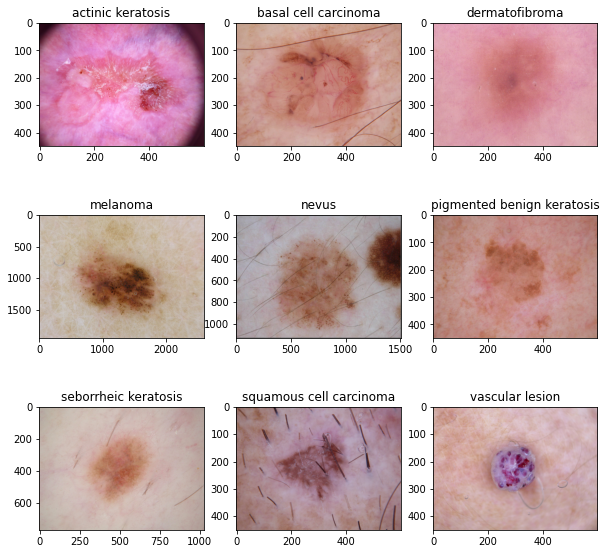

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(train_data_directory.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

## Observations:

*   All the images are not in same size or shape.
*   Due to this imbalance in size of images it's needs to be rescaled to a same dimension.




The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Performing auto tuning on the train and validation data before model building.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

## First Base Model

#### Creating a trainable CNN model to accurately predict 9 different category or classes of images

```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
#Base CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choosing 'Adam' as optimization technique for the model and SparseCategoricalCrossentropy as loss function

In [12]:
# applying optimizer and loss function
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [15]:
epochs = 20
batch_size = 32

history = model.fit(
  train_data,
  batch_size=batch_size,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 55s 993ms/step - loss: 1.9792 - accuracy: 0.2846 - val_loss: 1.7278 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6367 - accuracy: 0.4146 - val_loss: 1.5594 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4921 - accuracy: 0.4760 - val_loss: 1.5296 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4325 - accuracy: 0.5028 - val_loss: 1.4583 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3451 - accuracy: 0.5229 - val_loss: 1.3836 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2384 - accuracy: 0.5547 - val_loss: 1.3582 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.2091 - accuracy: 0.5776 - val_loss: 1.3633 - val_accuracy: 0.5213
Epoch 8/20


### Visualizing training results

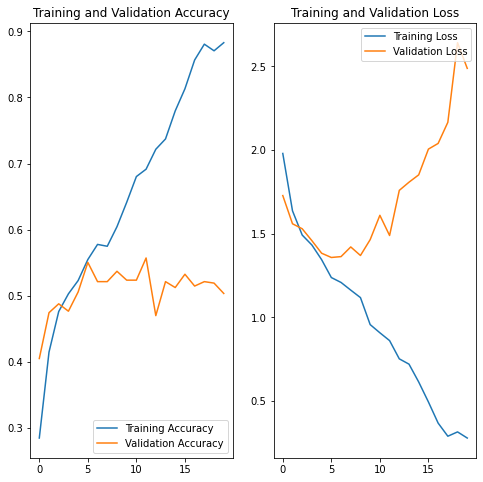

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observation and Findings:


*   **As epochs count increases difference between training and validation accuracy increases.**
*   **Due to this difference in accuracy after 7-8 epochs it clearly indicates that the model is overfitting.**



### To control the this overfitting we are applying data augmentation strategies like RandomFlip, RandomRotation, RandomZoom & RandomTransition to augment the present images.

In [17]:
rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range  
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


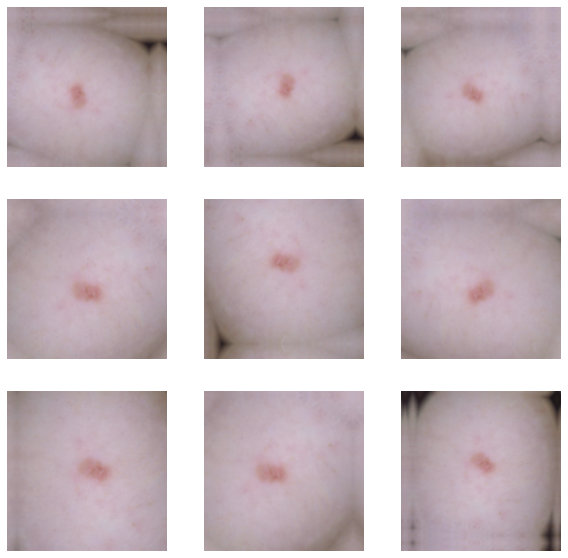

In [18]:
#Visualizing the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(2):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")   

## Model Re-Building

To improve the model performance following modifications have been implemented on the first model and a new model architecture is been prepared.

*   Adding the augmentation layer into the model
*   Adding drop out layers to control overfitting after convolution layers.




### Model 2


In [19]:
# Model 2

model2 = Sequential()                     #Sequential allows you to create models layer-by-layer  

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [20]:
# applying optimizer and loss function
model2.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Training model for 20 epochs
epochs = 20
batch_size = 32

history = model2.fit(
  train_data,
  batch_size=batch_size,
  validation_data=validation_data,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 [==============================] - 5s 52ms/step - loss: 2.4583 - accuracy: 0.1875 - val_loss: 2.0998 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 2.0724 - accuracy: 0.1914 - val_loss: 2.0726 - val_accuracy: 0.2640
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 2.0478 - accuracy: 0.2065 - val_loss: 2.0430 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 3s 50ms/step - loss: 2.0287 - accuracy: 0.1925 - val_loss: 2.0912 - val_accuracy: 0.2349
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.9651 - accuracy: 0.2829 - val_loss: 1.8824 - val_accuracy: 0.3177
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8726 - accuracy: 0.2946 - val_loss: 1.7670 - val_accuracy: 0.3154
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7823 - accuracy: 0.3477 - val_loss: 1.6846 - val_accuracy: 0.4183
Epoch 8/20
56

### Visualizing the results

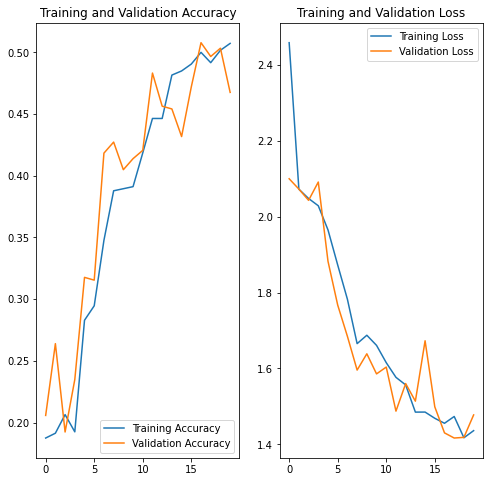

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observations & Findings :

*   After applying the augmentation and dropout layer overfitting problem in the model is reduced by a margin.
*   Model still shows underfitting and overfitting issues at some point of epochs.
*   Overall accuracy of the model is very less, around 60%.
*   Overall loss is also on the higher side.

As per above observations we further need to check for class imbalance in the present datasets.







## Finding the distribution of classes in the training dataset:

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### Class Imbalance Check:

In [23]:
def distribution_of_classes(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = distribution_of_classes(train_data_directory)
df.sort_values(by=['No. of Image'])

,Class,No. of Image
3,seborrheic keratosis,77
4,dermatofibroma,95
7,actinic keratosis,114
2,vascular lesion,139
8,squamous cell carcinoma,181
1,nevus,357
5,basal cell carcinoma,376
0,melanoma,438
6,pigmented benign keratosis,462


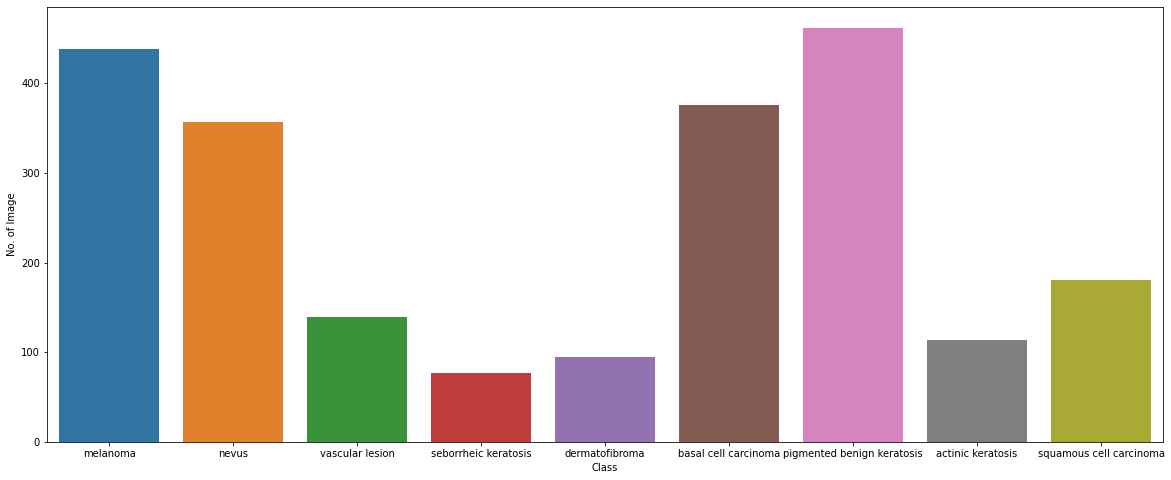

In [24]:
#Visualize the Number of image in each class.
plt.figure(figsize=(20, 8))
sns.barplot(x="Class", y="No. of Image", data=df,
            label="Class")

### Observations:

*   All the classes have different number of samples or training data, and its not averagely distributed.
*   Data imbalance is present the training data set classes.



# New Section
#### 1. **seborrheic keratosis class have least number of samples which is 77.**
#### 2. **pigmented benign keratosis (462 Samples), melanoma (438 Samples), basal cell carcinoma (376 Samples), and nevus (357 Samples) classes dominates the data in terms proportionate number of samples.**


## Rectify the class imbalance


### We will be using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
# install the package
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
# path to the train data directory
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# applying the augmentor
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A124F5450>: 100%|██████████| 500/500 [00:20<00:00, 24.88 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A37083990>: 100%|██████████| 500/500 [00:20<00:00, 24.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3A12522050>: 100%|██████████| 500/500 [00:22<00:00, 21.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3A123CC4D0>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A124A7090>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A12522350>: 100%|██████████| 500/500 [00:17<00:00, 27.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3B545B7810>: 100%|██████████| 500/500 [00:44<00:00, 11.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A12759B10>: 100%|██████████| 500/500 [00:21<00:00, 23.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A37132FD0>: 100%|██████████| 500/500 [00:20<00:00, 24.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
trained_image_count = len(list(train_data_directory.glob('*/output/*.jpg')))
print(trained_image_count)

4500


#### Total 4500 (500 * 9 classes ) new samples added.

## Lets see the distribution of augmented data after adding new images to the original training data:

In [28]:
# updated directory path list
updated_path_list = [x for x in glob(os.path.join(train_data_directory, '*','output', '*.jpg'))]
updated_path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_77e3fd86-a687-4c85-8760-086c5e3f54c9.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011077.jpg_0879dcbe-c7c2-4865-8a4a-2d1af98d8b04.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010799.jpg_486f3359-2506-4899-9463-23784244ad3d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000279.jpg_cc1df323-644d-4438-afaa-3daedc41cb56.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001132.jpg_7e4dd1cc-d51a-44bb-913a-aad9d17142e0.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International

In [29]:
# updated class name list
new_class_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data_directory, '*','output', '*.jpg'))]
new_class_list

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [30]:
# creating a new dataframe of training data 
for i in class_names:
      
    for j in train_data_directory.glob(i+'/*.jpg'):
        updated_path_list.append(str(j))
        new_class_list.append(i)
dataframe_dict_original = dict(zip(updated_path_list, new_class_list))
dataframe_new = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
dataframe_new

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
...,...,...
6734,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
6735,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
6736,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
6737,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [31]:
# total sample count in each class
dataframe_new['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Creating a Final Model:

### Based on newly augmented data and increased number of samples we will create new train and validation data sets and will be building final model on top of that data.

In [32]:
# pre defined parameters 
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset (8:2 ratios):

In [33]:
train_data_directory="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_directory,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset (8:2 ratio) :

In [34]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_directory,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Final Model building with normalization :

In [35]:
## Model 3

model3 = Sequential()                     #Sequential allows you to create models layer-by-layer  

model3.add(rescale)                       #Rescaling layer

# Physical augmentation layer removed as we already applied augmentation on whole train data directory.

#First Convulation Layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization 
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

model3.add(layers.BatchNormalization())

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model3.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile model:
Choosing 'Adam' as optimization technique for the model and SparseCategoricalCrossentropy as loss function

In [36]:
### applying optimiser and loss function
model3.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the Model :

To increse the model performance we are now applying **30 epochs**.

In [37]:
epochs = 30

# fitting the model
history = model3.fit(train_data,epochs=epochs,validation_data=validation_data,verbose=1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 37s 205ms/step - loss: 2.2934 - accuracy: 0.2233 - val_loss: 3.4216 - val_accuracy: 0.1425
Epoch 2/30
169/169 [==============================] - 31s 176ms/step - loss: 1.7160 - accuracy: 0.3628 - val_loss: 2.5334 - val_accuracy: 0.2717
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.5152 - accuracy: 0.4245 - val_loss: 1.8674 - val_accuracy: 0.2977
Epoch 4/30
169/169 [==============================] - 31s 179ms/step - loss: 1.4173 - accuracy: 0.4664 - val_loss: 1.7404 - val_accuracy: 0.3148
Epoch 5/30
169/169 [==============================] - 32s 184ms/step - loss: 1.3324 - accuracy: 0.5009 - val_loss: 1.6435 - val_accuracy: 0.3586
Epoch 6/30
169/169 [==============================] - 31s 175ms/step - loss: 1.2890 - accuracy: 0.5150 - val_loss: 1.6626 - val_accuracy: 0.3935
Epoch 7/30
169/169 [==============================] - 31s 175ms/step - loss: 1.2263 - accuracy: 0.5382 - val_loss: 1.7866 - val_accuracy: 0.3

### Visualizing the model results:

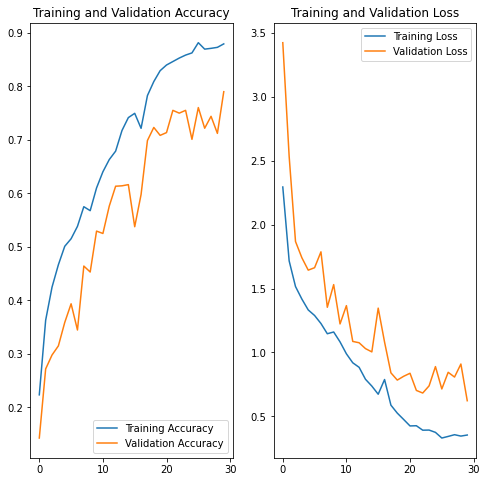

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observation and Findings :


### 1.   Class rebalancing and augmentation helps achieving the better training  and validation accuracy.
### 2.   Model overfitting and underfitting issue is resolved now.
### 3.   We have achieved better model accuracy with maximum of 87% training accuracy and 78% of validation accuracy.
### 4.  Also, overall loss is reduced it is around 0.3 for training and 0.6 for validation. 



### **We have achieved good model result using this model, using the same as our final model we will re run the model one more time with higher epoch count to see if model performance increases.**

## Final Model with Higher Epoch:

In [39]:
##Final Model

finalModel = Sequential()                     #Sequential allows you to create models layer-by-layer  

finalModel.add(rescale)                       #Rescaling layer

#First Convulation Layer
finalModel.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
finalModel.add(layers.MaxPool2D(pool_size=(2,2)))
finalModel.add(layers.Dropout(0.25))

#Second Convulation Layer
finalModel.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
finalModel.add(layers.MaxPool2D(pool_size=(2,2)))
finalModel.add(layers.Dropout(0.25))

#Third Convulation Layer
finalModel.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
finalModel.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
finalModel.add(layers.Flatten())

#Dense Layer
finalModel.add(layers.Dense(512,activation='relu'))
finalModel.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization 
finalModel.add(layers.BatchNormalization())

#Dense Layer
finalModel.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
finalModel.add(layers.Dropout(0.50))

finalModel.add(layers.BatchNormalization())

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
finalModel.add(layers.Dense(len(class_names),activation='softmax'))

In [40]:
### applying optimiser and loss function
finalModel.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## **Running the Model with Epoch = 50**

In [41]:
epochs = 50

#fitting the model
history = finalModel.fit(train_data,epochs=epochs,validation_data=validation_data,verbose=1)

Epoch 1/50
169/169 [==============================] - 32s 179ms/step - loss: 2.5712 - accuracy: 0.1508 - val_loss: 3.9471 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 31s 178ms/step - loss: 2.2279 - accuracy: 0.1997 - val_loss: 7.1356 - val_accuracy: 0.1359
Epoch 3/50
169/169 [==============================] - 31s 175ms/step - loss: 1.9310 - accuracy: 0.2767 - val_loss: 3.4146 - val_accuracy: 0.1477
Epoch 4/50
169/169 [==============================] - 31s 176ms/step - loss: 1.7343 - accuracy: 0.3305 - val_loss: 3.1267 - val_accuracy: 0.1930
Epoch 5/50
169/169 [==============================] - 32s 182ms/step - loss: 1.5628 - accuracy: 0.3991 - val_loss: 1.9938 - val_accuracy: 0.2940
Epoch 6/50
169/169 [==============================] - 31s 176ms/step - loss: 1.5679 - accuracy: 0.3971 - val_loss: 1.7434 - val_accuracy: 0.2762
Epoch 7/50
169/169 [==============================] - 30s 175ms/step - loss: 1.5032 - accuracy: 0.4227 - val_loss: 1.8968 - val_ac

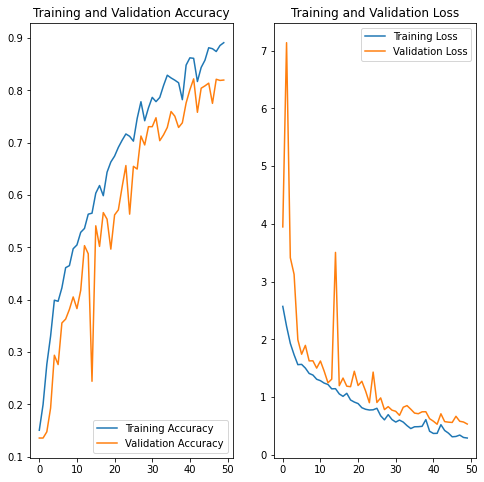

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observation and Findings :

With the increase in epoch count we observe following things - 

1.   **Overall model accuracy increases, now we have 90% training accuracy and 80% validation accuracy.** 
2.   **Model performs better with higher iteration value that is high epoch.**
3.   **Overall loss is also reduced to for training 0.3 and validation 0.5.** 



### We achieved the better result using the same model, but the above graph shows some high spike in certain epoch and very unstability at some point which shows drop in accuracy and increase is loss.

### This situation can be handled with adding more samples in to the data and perform some more data engineering steps.

# Prediction :

In [43]:
# reading the test data from the directory

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_directory,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


## Predicting the Melanoma Class using the Final Model on test data :

Actual Class nevus
Predictive Class nevus


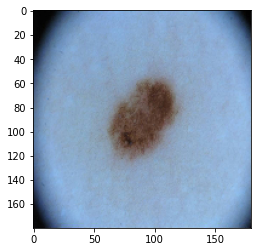

In [48]:
Test_image_path = os.path.join(test_data_directory, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = finalModel.predict(img) ## using predict on final model
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )

## Observation:

## **We have given Nevus Class name for prediction and the model successfully predicts an image which belongs to Nevus Class.**

## Flow Chart of Final Model:

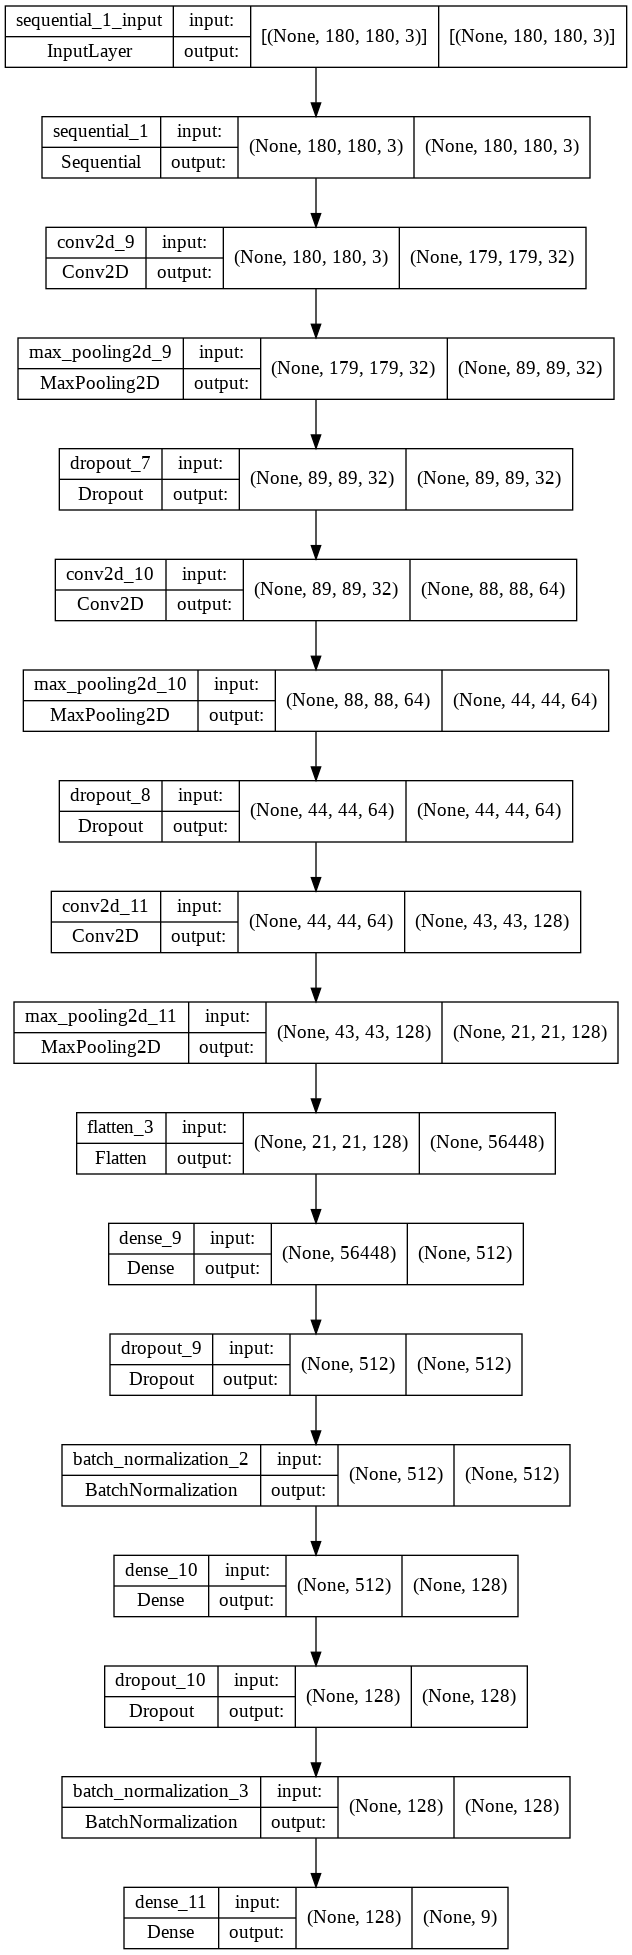

In [49]:
# plotting the model

plot_model(finalModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

==================== END =============================